In [1]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from wordcloud import WordCloud
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
### Loading Data
data_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/data.csv'
tag_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/tag.csv'
data = pd.read_csv(data_file_path)
tag = pd.read_csv(tag_file_path)

In [3]:
pd.set_option('display.max_columns',30)

In [4]:
data.head(5)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14


## Limpiando el target

 Sacamos las columnas que no nos van a hacer falta, ya que queremos predecir si cargará o no

In [5]:
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)

Sumaremos todas las cargas que realizaron

In [6]:
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)

In [7]:
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

Reemplazamos la cantidad de cargar por "False" si cargó, y "True" si no cargó 

In [8]:
tag['Total']= tag['Total']==0

In [9]:
tag.rename(columns={'Total':'Target'},inplace=True)

In [10]:
tag['Target'] = tag['Target'].astype(int)

 Unimos los datasets

In [11]:
fulldata = data.merge(tag, on='SUSCRIBER_KEY')

In [12]:
del tag
del data

 # Limpieza de columnas 

Todas las que dicen en el documento 'No se usa'

In [13]:
fulldata.drop(columns=[x for x in fulldata.columns if 'ARPU' in x],inplace=True)

Quedaron 5 a eliminar (quedaban 190 después de que el profe eliminó las innecesarias)

In [14]:
que_quedaron= ["USE_LCL_VOI_AMT_M1", "USE_LCL_VOI_AMT_M2","USE_LCL_VOI_AMT_M3",]

In [15]:
fulldata.drop(columns=que_quedaron,inplace=True)

In [16]:
fulldata.shape

(319222, 192)

Removemos columnas que tienen un solo valor 

In [17]:
columnas_a_eliminar = [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [18]:
fulldata.drop(columns=columnas_a_eliminar, inplace=True)

In [19]:
fulldata.shape

(319222, 190)

## Veamos ahora los nulos

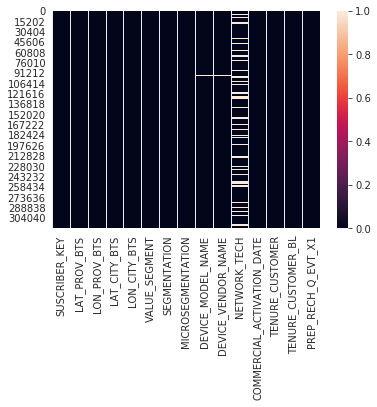

In [20]:
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull())

In [21]:
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

Hasta ahí los nulos eran una lista. Ahora con pandas los convertimos en un array

In [22]:
missing = pd.Series(nullcount)

In [23]:
missing

SUSCRIBER_KEY          0
LAT_PROV_BTS         734
LON_PROV_BTS         734
LAT_CITY_BTS         734
LON_CITY_BTS         734
                    ... 
PACK_DATA_EXP_W9       0
PACK_DATA_EXP_W10      0
PACK_DATA_EXP_W11      0
PACK_DATA_EXP_W12      0
Target                 0
Length: 190, dtype: int64

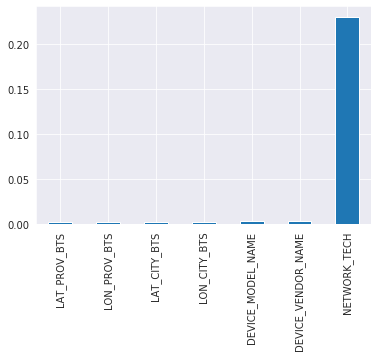

In [24]:
missing[missing>0].div(fulldata.shape[0]).plot.bar()

---

# Limpieza de datos categóricos

---

Analizamos los datos categoricos

In [25]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 190 entries, SUSCRIBER_KEY to Target
dtypes: float64(82), int64(98), object(10)
memory usage: 465.2+ MB


In [26]:
cols = fulldata.columns 
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(cols) - set(num_cols))

In [27]:
cat_columns

['SUSCRIBER_KEY',
 'PREP_RECH_LAST_DAY_12W',
 'MICROSEGMENTATION',
 'COMMERCIAL_ACTIVATION_DATE',
 'SEGMENTATION',
 'DEVICE_VENDOR_NAME',
 'VALUE_SEGMENT',
 'PREP_RECH_CHNNL_MODE12W',
 'NETWORK_TECH',
 'DEVICE_MODEL_NAME']

In [28]:
Cat_fulldata =  fulldata[cat_columns].copy()

In [29]:
Cat_fulldata.head(5)

,SUSCRIBER_KEY,PREP_RECH_LAST_DAY_12W,MICROSEGMENTATION,COMMERCIAL_ACTIVATION_DATE,SEGMENTATION,DEVICE_VENDOR_NAME,VALUE_SEGMENT,PREP_RECH_CHNNL_MODE12W,NETWORK_TECH,DEVICE_MODEL_NAME
0,E_63734494_20190215,19-AUG-19,PD1,15-FEB-19,2-PD,LG,3 - SILVER,"N/A,3;UGW,9",LTE,G4 STYLUS (H540)
1,E_66977552_20190518,03-JUL-19,LOW3,18-MAY-19,7-LOW,NOT_IDENTIFIED,4 - BRONZE,"UGW,1",NaN,NOT_IDENTIFIED
2,E_69159695_20180116,02-SEP-19,LOW4,16-JAN-18,6-OH,NOT_IDENTIFIED,3 - SILVER,"N/A,3;UGW,4",3G,NOT_IDENTIFIED
3,E_65255730_20190416,01-SEP-19,LOW3,16-APR-19,7-LOW,BLU,3 - SILVER,"UGW,2",LTE,JENNY TV 2.8
4,E_67893872_20161201,05-SEP-19,DO3,01-DEC-16,3-DO,SAMSUNG,3 - SILVER,"N/A,1;UGW,4",LTE,GALAXY J1 (SM-J111MDS)


Logramos identificar que las columas network tech, device vendor model y device vendor name tienen valores nulos ya sea como 'NaN' o como 'NOT_IDENTIFIED'. Por eso decidimos imputarlos..

## Imputar network tech

In [30]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.467399
3G     0.272118
NaN    0.229959
2G     0.030524
Name: NETWORK_TECH, dtype: float64

Vemos que dentro de los valores tenemos un 22% que son NaN

In [31]:
fulldata['NETWORK_TECH'].value_counts(dropna=False)

LTE    149204
3G      86866
NaN     73408
2G       9744
Name: NETWORK_TECH, dtype: int64

Calculamos la moda de la columna NETWORK_TECH para luego reemplazarla por los valores NaN

In [32]:
moda_network_tech=fulldata['NETWORK_TECH'].mode()
moda_network_tech[0]

'LTE'

In [33]:
fulldata['NETWORK_TECH'].fillna(moda_network_tech[0], inplace=True)

In [34]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.697358
3G     0.272118
2G     0.030524
Name: NETWORK_TECH, dtype: float64

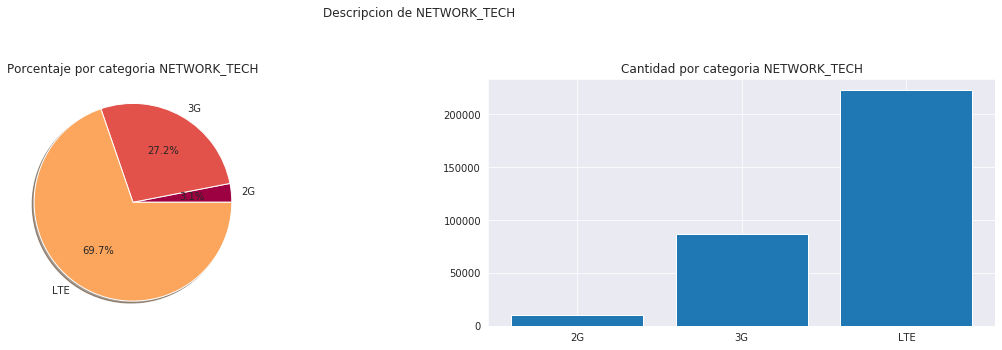

In [35]:
pie_labels=fulldata['NETWORK_TECH'].sort_values().unique()
pie_data_cantidad=fulldata['NETWORK_TECH'].value_counts(dropna=False).sort_values()
pie_data_porcentaje=fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False).sort_values()
#explode= (0,0.1,0)
plt.figure(1,figsize=(20,10))
the_grid=GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors=[cmap(i) for i in np.linspace(0,1,8)]
#Grafico de cantidades de NETWORK_TECH
plt.subplot(the_grid[0,1], title='Cantidad por categoria NETWORK_TECH')
cantidades_pie=plt.bar(pie_labels ,pie_data_cantidad)
#Grafico de porcentajes de NETWORK_TECH
plt.subplot(the_grid[0,0], title='Porcentaje por categoria NETWORK_TECH')
porcentaje_pie=plt.pie(pie_data_porcentaje, labels=pie_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.suptitle('Descripcion de NETWORK_TECH')

plt.show()

Vemos que el 22% de NaN paso a LTE 

## Imputar device model name

In [36]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

NOT_IDENTIFIED                           0.134881
GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.105281
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
                                           ...   
AURA (S401)                              0.000003
S3503                                    0.000003
CPH1605                                  0.000003
GT-B3210                                 0.000003
ZENFONE 6 (T00G)                         0.000003
Name: DEVICE_MODEL_NAME, Length: 2477, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_MODEL_NAME son 'NOT_IDENTIFIED', con lo cual procedemos a inputar los datos por el valor de la moda.

In [37]:
device_model_name=fulldata[fulldata['DEVICE_MODEL_NAME']!='NOT_IDENTIFIED']
moda_device_model_name=device_model_name.DEVICE_MODEL_NAME.mode()
moda_device_model_name[0]

'GALAXY GRAND PRIME DUOS (SM-G532M DS)'

In [38]:
fulldata['DEVICE_MODEL_NAME'].replace({'NOT_IDENTIFIED':moda_device_model_name[0]},inplace=True)

In [39]:
fulldata['DEVICE_MODEL_NAME'].fillna(moda_device_model_name[0], inplace=True)

In [40]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.242916
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
GALAXY J2 PRIME (SM-G532M)               0.020259
                                           ...   
U972                                     0.000003
STARRY                                   0.000003
K550I                                    0.000003
RAZR I XT890                             0.000003
ENERGY X 2                               0.000003
Name: DEVICE_MODEL_NAME, Length: 2475, dtype: float64

Vemos que los valores de 'NOT_IDENTIFIED' se reemplazaron por la moda.

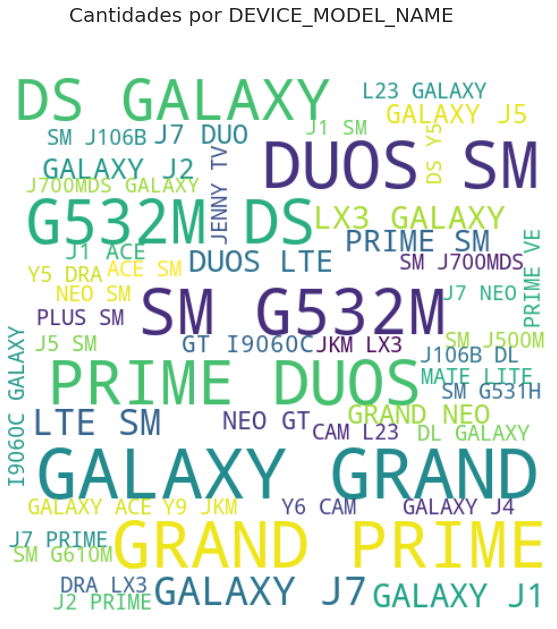

In [41]:
text=' '.join(fulldata['DEVICE_MODEL_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=50).generate(text)

plt.figure(1,figsize=(20,10))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_MODEL_NAME', fontsize=20)
plt.show()


## Imputar device vendor name

In [42]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG           0.502356
HUAWEI            0.173418
NOT_IDENTIFIED    0.134881
LG                0.051610
BLU               0.030712
                    ...   
HTW               0.000003
OPTION            0.000003
MASTER            0.000003
CHANGJIANG        0.000003
SEIKO             0.000003
Name: DEVICE_VENDOR_NAME, Length: 234, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_V.ENDOR_NAME son 'NOT_IDENTIFIED', por lo que procedemos a reemplazar los valores por la moda 

In [43]:
device_vendor_name=fulldata[fulldata['DEVICE_VENDOR_NAME']!='NOT_IDENTIFIED']
moda_device_vendor_name=device_vendor_name.DEVICE_VENDOR_NAME.mode()
moda_device_vendor_name[0]

'SAMSUNG'

In [44]:
fulldata['DEVICE_VENDOR_NAME'].replace({'NOT_IDENTIFIED':moda_device_vendor_name[0]},inplace=True)
fulldata['DEVICE_VENDOR_NAME'].fillna(moda_device_vendor_name[0], inplace=True)
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG       0.639990
HUAWEI        0.173418
LG            0.051610
BLU           0.030712
NOKIA         0.026953
                ...   
MOVI          0.000003
NKTEL         0.000003
OKWAP         0.000003
NYX-MOBILE    0.000003
SEIKO         0.000003
Name: DEVICE_VENDOR_NAME, Length: 232, dtype: float64

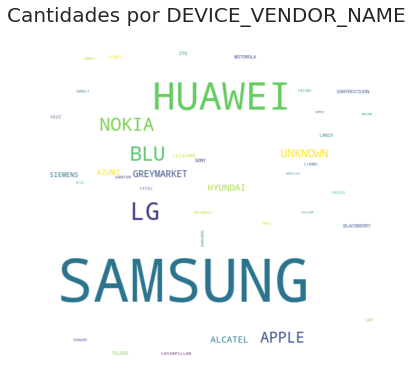

In [45]:
text=' '.join(fulldata['DEVICE_VENDOR_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=40).generate(text)
plt.figure(figsize=(6,6))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_VENDOR_NAME', fontsize=20)
plt.show()


Los valores de NOT_IDENTIFIED fueron reemplazados por su moda, que en este caso es 'SAMSUNG'.

---

# Limpieza de datos numéricos

---

Ahora procedemos a limpiar los datos numericos, para esto separamos el data set en datos referidos a las recargas, pack y a trafico de datos.

## Limpieza de datos de Pack

Primero separamos las columnas que son de datos referidos a los packs

In [46]:
Pack_columns=['SUSCRIBER_KEY']
for a in cols:
    if a.startswith('PACK_'):
        Pack_columns.append(a)

In [47]:
Pack_fulldata=fulldata[Pack_columns]
Pack_fulldata

,SUSCRIBER_KEY,PACK_DATA_Q_X1,PACK_DATA_Q_X2,PACK_DATA_Q_X3,PACK_DATA_AMT_X1,PACK_DATA_AMT_X2,PACK_DATA_AMT_X3,PACK_VOICE_Q_X1,PACK_VOICE_Q_X2,PACK_VOICE_Q_X3,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_X3,PACK_SMS_Q_X1,PACK_SMS_Q_X2,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,4,5,4,6.00,9.0,6.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,0,0,0,0.00,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,5,3,3,4.50,3.0,1.50,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,3,0,0,0.99,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,3,4,3,8.99,9.0,10.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,0,0,4,0.00,0.0,4.99,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,3,10,0
319218,E_65347728_20171017,3,5,7,3.00,6.0,10.48,4,4,7,3.98,3.98,9.95,0,0,...,0.0,0.0,0.0,0,0,0,8,9,0,4,11,10,7,13,7
319219,E_68063707_20150701,0,0,0,0.00,0.0,0.00,0,3,0,0.00,1.99,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
319220,E_67206080_20181010,0,0,3,0.00,0.0,5.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,5,12


Comparamos las columnas de pack semanal contra las mensuales para buscar datos incorrectos o verificar si la informacion es duplicada.

### Para la cantidad de pack de datos :

In [48]:
Pack_fulldata[['PACK_DATA_Q_W1','PACK_DATA_Q_W2','PACK_DATA_Q_W3','PACK_DATA_Q_W4','PACK_DATA_Q_X1','PACK_DATA_Q_W5','PACK_DATA_Q_W6','PACK_DATA_Q_W7','PACK_DATA_Q_W8','PACK_DATA_Q_X2','PACK_DATA_Q_W9','PACK_DATA_Q_W10','PACK_DATA_Q_W11','PACK_DATA_Q_W12','PACK_DATA_Q_X3']]

,PACK_DATA_Q_W1,PACK_DATA_Q_W2,PACK_DATA_Q_W3,PACK_DATA_Q_W4,PACK_DATA_Q_X1,PACK_DATA_Q_W5,PACK_DATA_Q_W6,PACK_DATA_Q_W7,PACK_DATA_Q_W8,PACK_DATA_Q_X2,PACK_DATA_Q_W9,PACK_DATA_Q_W10,PACK_DATA_Q_W11,PACK_DATA_Q_W12,PACK_DATA_Q_X3
0,0,0,3,3,4,3,4,0,0,5,4,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,3,5,0,3,0,0,3,0,0,3,0,3
3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,3,0,3,0,3,4,0,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4
319218,0,0,0,3,3,3,0,0,4,5,3,3,4,3,7
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3


Vemos que hay inconsistencias entre las cantidades semanales y las mensuales, por ende la informacion es incorrecta.
Eliminamos las columnas con la premisa de no meter basura en el modelo.

In [49]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_Q' in x],inplace=True)

### Para los montos de pack de datos:

In [50]:
Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_X1','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_X2','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12','PACK_DATA_AMT_X3']]


,PACK_DATA_AMT_W1,PACK_DATA_AMT_W2,PACK_DATA_AMT_W3,PACK_DATA_AMT_W4,PACK_DATA_AMT_X1,PACK_DATA_AMT_W5,PACK_DATA_AMT_W6,PACK_DATA_AMT_W7,PACK_DATA_AMT_W8,PACK_DATA_AMT_X2,PACK_DATA_AMT_W9,PACK_DATA_AMT_W10,PACK_DATA_AMT_W11,PACK_DATA_AMT_W12,PACK_DATA_AMT_X3
0,0.0,0.0,3.00,3.00,6.00,3.0,6.0,0.0,0.0,9.0,6.0,0.0,0.00,0.00,6.00
1,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,1.5,0.0,1.50,1.50,4.50,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.50,0.00,1.50
3,0.0,0.0,0.99,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
4,0.0,0.0,0.00,8.99,8.99,0.0,5.0,0.0,4.0,9.0,0.0,10.0,0.00,0.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.99,0.00,4.99
319218,0.0,0.0,0.00,3.00,3.00,1.5,0.0,0.0,4.5,6.0,1.5,1.5,4.50,2.98,10.48
319219,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
319220,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.00,5.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de datos.

In [51]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_AMT_X' in x],inplace=True)

Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

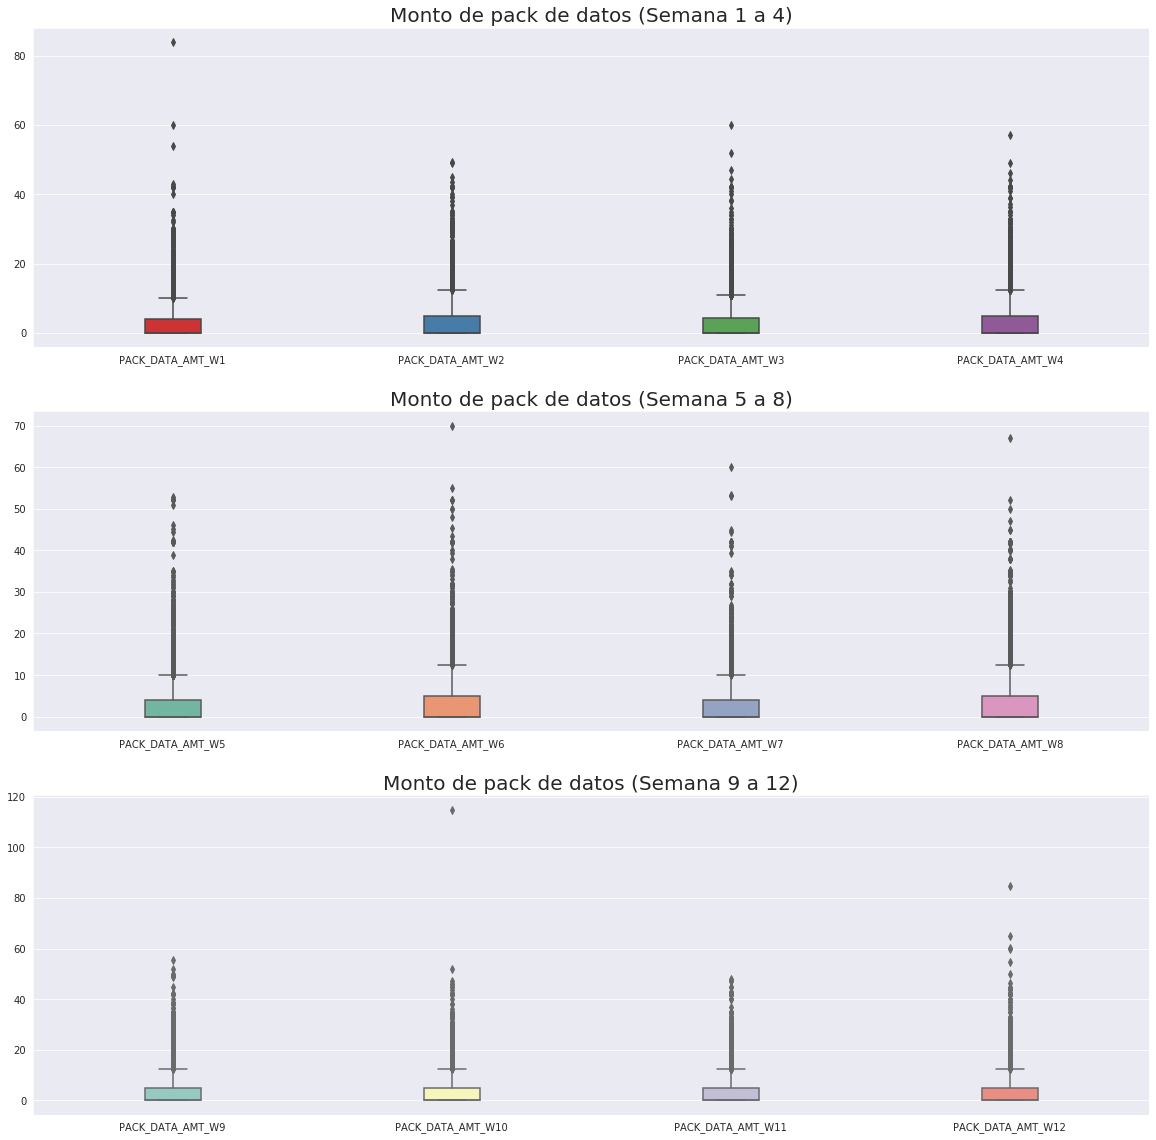

In [52]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=Pack_fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=Pack_fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)

Vemos que tenemos outliers por lo que procedemos a la eliminacion de los mismos segun esten en el primer o tercer quartil y multiplicando por 1.5 

In [53]:
for column in fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]:
    Q1 = fulldata[column].quantile(0.25)
    Q3 = fulldata[column].quantile(0.75)
    IQR = Q3 - Q1
    fulldata[column] = np.where((fulldata[column] < (Q1 - 1.5 * IQR)) | (fulldata[column] > (Q3 + 1.5 * IQR)), fulldata[column].median(), fulldata[column])


Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

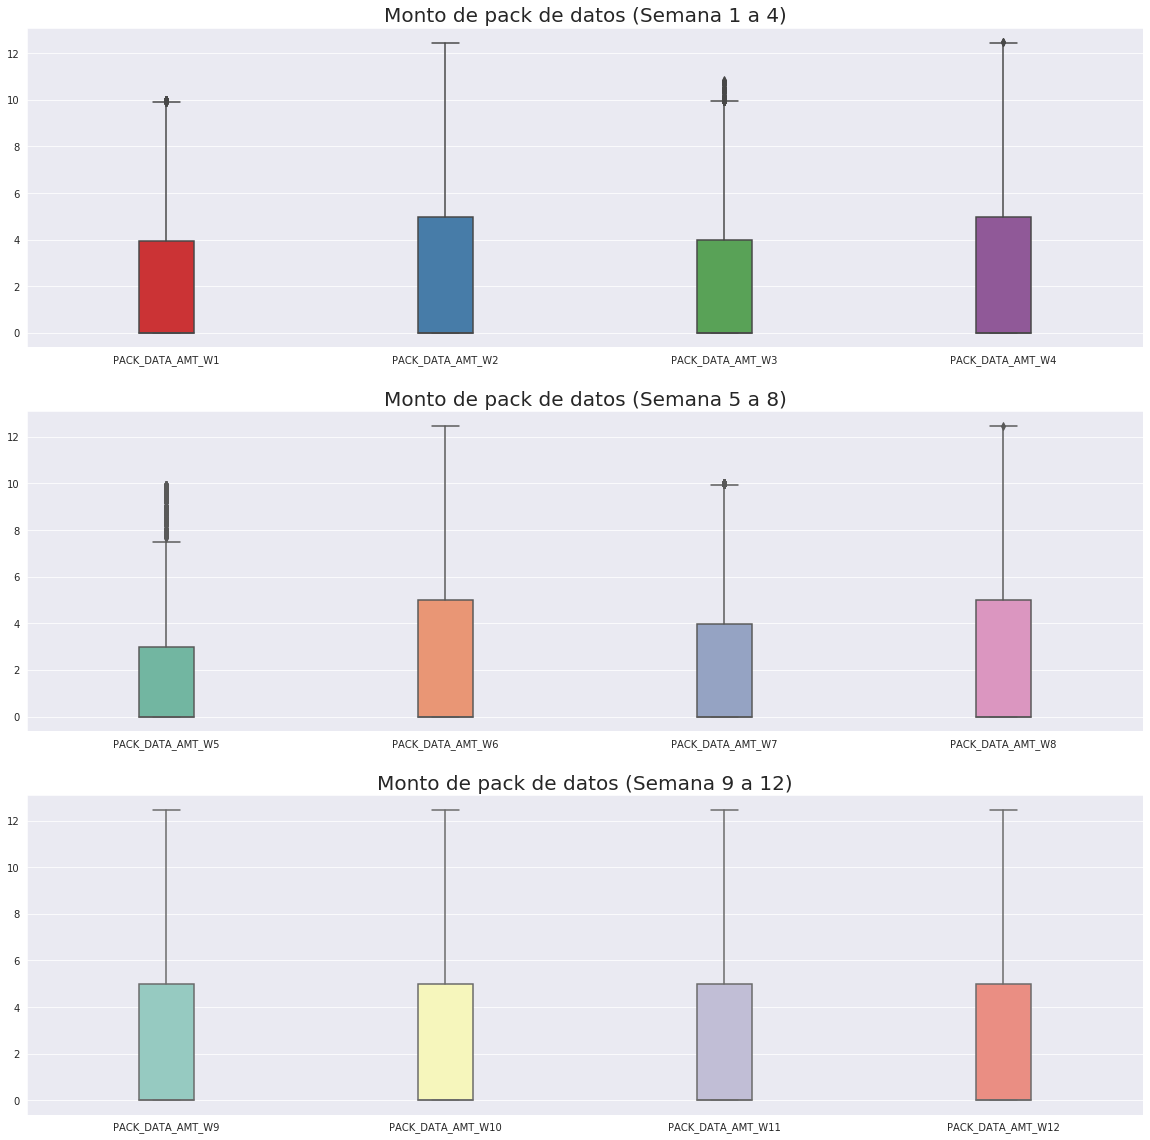

In [54]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)


### Para la cantidad de pack de sms:

In [55]:
Pack_fulldata[['PACK_SMS_Q_W1','PACK_SMS_Q_W2','PACK_SMS_Q_W3','PACK_SMS_Q_W4','PACK_SMS_Q_X1','PACK_SMS_Q_W5','PACK_SMS_Q_W6','PACK_SMS_Q_W7','PACK_SMS_Q_W8','PACK_SMS_Q_X2','PACK_SMS_Q_W9','PACK_SMS_Q_W10','PACK_SMS_Q_W11','PACK_SMS_Q_W12','PACK_SMS_Q_X3']]

,PACK_SMS_Q_W1,PACK_SMS_Q_W2,PACK_SMS_Q_W3,PACK_SMS_Q_W4,PACK_SMS_Q_X1,PACK_SMS_Q_W5,PACK_SMS_Q_W6,PACK_SMS_Q_W7,PACK_SMS_Q_W8,PACK_SMS_Q_X2,PACK_SMS_Q_W9,PACK_SMS_Q_W10,PACK_SMS_Q_W11,PACK_SMS_Q_W12,PACK_SMS_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Vemos que las columnas de los pack de sms semanales no coinciden con el correspondiente acumulado mensual, por lo que se considera dato incorrecto y se elimina del dataset.

In [56]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_Q' in x],inplace=True)

### Para los montos en sms:

In [57]:
Pack_fulldata[['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4','PACK_SMS_AMT_X1','PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8','PACK_SMS_AMT_X2','PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12','PACK_SMS_AMT_X3']]

,PACK_SMS_AMT_W1,PACK_SMS_AMT_W2,PACK_SMS_AMT_W3,PACK_SMS_AMT_W4,PACK_SMS_AMT_X1,PACK_SMS_AMT_W5,PACK_SMS_AMT_W6,PACK_SMS_AMT_W7,PACK_SMS_AMT_W8,PACK_SMS_AMT_X2,PACK_SMS_AMT_W9,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_SMS_AMT_X3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En este caso los montos si coinciden, por lo cual se eliminan las columnas de acumulados para no repetir informacion.

In [58]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_AMT_X' in x],inplace=True)

### Para la cantidad de pack de voz:

In [59]:
Pack_fulldata[['PACK_VOICE_Q_W1','PACK_VOICE_Q_W2','PACK_VOICE_Q_W3','PACK_VOICE_Q_W4','PACK_VOICE_Q_X1','PACK_VOICE_Q_W5','PACK_VOICE_Q_W6','PACK_VOICE_Q_W7','PACK_VOICE_Q_W8','PACK_VOICE_Q_X2','PACK_VOICE_Q_W9','PACK_VOICE_Q_W10','PACK_VOICE_Q_W11','PACK_VOICE_Q_W12','PACK_VOICE_Q_X3']]

,PACK_VOICE_Q_W1,PACK_VOICE_Q_W2,PACK_VOICE_Q_W3,PACK_VOICE_Q_W4,PACK_VOICE_Q_X1,PACK_VOICE_Q_W5,PACK_VOICE_Q_W6,PACK_VOICE_Q_W7,PACK_VOICE_Q_W8,PACK_VOICE_Q_X2,PACK_VOICE_Q_W9,PACK_VOICE_Q_W10,PACK_VOICE_Q_W11,PACK_VOICE_Q_W12,PACK_VOICE_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,4,4,3,0,0,3,4,0,4,0,5,7
319219,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Aca vemos que las cantidades semanales no se corresponden con los acumulados mensuales, lo tomamos como valores incorrectos y procedemos a borrarlos

In [60]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_Q' in x],inplace=True)


### Para el monto de pack de voz:

In [61]:
Pack_fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4','PACK_VOICE_AMT_X1','PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8','PACK_VOICE_AMT_X2','PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12','PACK_VOICE_AMT_X3']]

,PACK_VOICE_AMT_W1,PACK_VOICE_AMT_W2,PACK_VOICE_AMT_W3,PACK_VOICE_AMT_W4,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_W5,PACK_VOICE_AMT_W6,PACK_VOICE_AMT_W7,PACK_VOICE_AMT_W8,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_W9,PACK_VOICE_AMT_W10,PACK_VOICE_AMT_W11,PACK_VOICE_AMT_W12,PACK_VOICE_AMT_X3
0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
1,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
2,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
3,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
4,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
319218,0.0,0.0,0.0,3.98,3.98,1.99,0.00,0.0,1.99,3.98,0.0,3.98,0.0,5.97,9.95
319219,0.0,0.0,0.0,0.00,0.00,0.00,1.99,0.0,0.00,1.99,0.0,0.00,0.0,0.00,0.00
319220,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de voz.

In [62]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_AMT_X' in x],inplace=True)

In [63]:
fulldata.shape

(319222, 136)

---

## Limpieza de datos de tráfico

---

In [64]:
traffic_columns = [traffic_column for traffic_column in fulldata.columns if traffic_column.startswith("TR")]

In [65]:
len(traffic_columns)

33

#### Data frame solo con datos de tráfico

In [66]:
df_traffic = fulldata[traffic_columns].copy()

#### Corroborar si algun datao es NaN o null

In [67]:
any(df_traffic.isna().sum() != 0) or any(df_traffic.isnull().sum() != 0)

False

#### Selección de columnas

In [68]:
df_traffic.corr()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,TRD_IM_M2,TRD_IM_M3,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,...,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
TRD_M1,1.000000,0.819897,0.706444,0.880530,0.686740,0.589018,0.680411,0.576677,0.504866,0.593411,0.502507,0.448108,-0.981298,-0.800250,-0.692806,...,-0.021242,-0.057533,-0.065129,0.159353,0.129310,0.107154,0.134440,0.102743,0.077624,0.169570,0.137804,0.113377,-0.000773,-0.002232,-0.004701
TRD_M2,0.819897,1.000000,0.812299,0.704101,0.849376,0.686593,0.568637,0.671875,0.563763,0.512410,0.595429,0.509747,-0.801601,-0.968443,-0.796362,...,-0.032868,-0.056186,-0.064748,0.133303,0.151496,0.121957,0.113338,0.122002,0.090125,0.141943,0.161491,0.129081,-0.000854,0.001362,-0.001865
TRD_M3,0.706444,0.812299,1.000000,0.602125,0.678701,0.877616,0.503848,0.570486,0.665991,0.457710,0.512473,0.596622,-0.695895,-0.795132,-0.986586,...,-0.043088,-0.066985,-0.063218,0.114486,0.130443,0.147253,0.094316,0.101494,0.105583,0.121747,0.138817,0.155561,-0.004722,-0.003314,-0.003169
TRD_STR_M1,0.880530,0.704101,0.602125,1.000000,0.764232,0.642544,0.371446,0.312305,0.267777,0.308190,0.259361,0.226853,-0.895387,-0.697189,-0.598833,...,-0.023074,-0.048766,-0.054645,0.124488,0.101716,0.086616,0.076968,0.058092,0.039714,0.129685,0.105906,0.089213,0.000450,0.000482,-0.001999
TRD_STR_M2,0.686740,0.849376,0.678701,0.764232,1.000000,0.751853,0.282610,0.333055,0.274304,0.254250,0.292309,0.247053,-0.688090,-0.873509,-0.683380,...,-0.028640,-0.045830,-0.052192,0.103430,0.117191,0.096966,0.056978,0.065639,0.042894,0.107090,0.121827,0.099642,-0.000372,0.002228,-0.000502
TRD_STR_M3,0.589018,0.686593,0.877616,0.642544,0.751853,1.000000,0.249587,0.284675,0.334460,0.220446,0.246592,0.289303,-0.584096,-0.675700,-0.889388,...,-0.036244,-0.053864,-0.053334,0.086192,0.098773,0.114020,0.043531,0.051642,0.053253,0.088952,0.102413,0.117524,-0.003120,-0.001942,-0.002279
TRD_SN_M1,0.680411,0.568637,0.503848,0.371446,0.282610,0.249587,1.000000,0.844782,0.749215,0.455462,0.392779,0.361107,-0.702335,-0.592182,-0.511767,...,-0.040526,-0.060806,-0.063290,0.065883,0.049784,0.035954,0.088585,0.066330,0.049818,0.073528,0.056111,0.040727,-0.005767,-0.007249,-0.007717
TRD_SN_M2,0.576677,0.671875,0.570486,0.312305,0.333055,0.284675,0.844782,1.000000,0.844078,0.403161,0.459169,0.407923,-0.596455,-0.698510,-0.579305,...,-0.046167,-0.061316,-0.063912,0.052568,0.060817,0.043548,0.076208,0.078627,0.058169,0.059258,0.068211,0.049022,-0.006036,-0.006423,-0.007252
TRD_SN_M3,0.504866,0.563763,0.665991,0.267777,0.274304,0.334460,0.749215,0.844078,1.000000,0.359763,0.399823,0.460776,-0.523048,-0.588081,-0.678881,...,-0.051216,-0.066013,-0.063408,0.039130,0.045987,0.051734,0.063119,0.064802,0.066499,0.044817,0.052227,0.057883,-0.006818,-0.007302,-0.006473
TRD_IM_M1,0.593411,0.512410,0.457710,0.308190,0.254250,0.220446,0.455462,0.403161,0.359763,1.000000,0.843178,0.753157,-0.597036,-0.531478,-0.457750,...,0.014308,-0.022118,-0.029371,0.170838,0.142321,0.119294,0.159099,0.125445,0.102146,0.183313,0.153102,0.127902,-0.002409,-0.006056,-0.006909


Plotear un heatmap de 33x33 es inviable, vamos a separar por tipo de dato:
1. Tráfico de datos
   * Total
   * Streaming
   * Redes sociales
   * Internet
2. Número de SMS
3. Tiempo de llamadas de voz
Y cada uno de estos los vamos a agrupar por por mes, para evaluar la relación que hay entre un mismo tipo de consumo por mes.

##### Correlación de variables de tráfico

**Tráfico de datos agrupados por tipo**

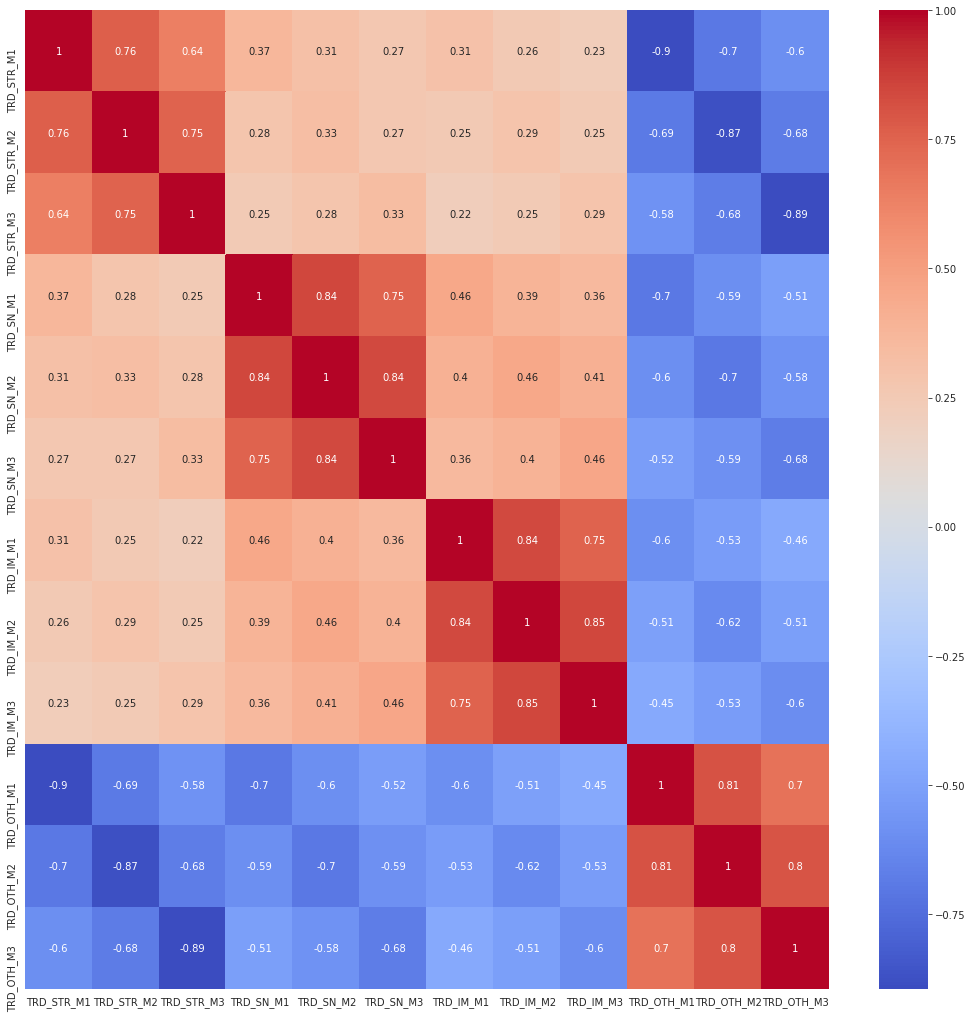

In [69]:
# FIXME: Corroborar que estas columnas tienen el total de los datos
total_data_columns = ['TRD_M1', 'TRD_M2', 'TRD_M3']
df_traffic_data_columns = [traffic_column for traffic_column in traffic_columns 
                           if traffic_column.startswith("TRD") 
                           and traffic_column not in  total_data_columns]
df_traffic_data_corr  = df_traffic[df_traffic_data_columns].corr()
# df_traffic_data_corr
plt.figure(figsize=(18, 18))
sns.heatmap(df_traffic_data_corr, annot=True, cmap='coolwarm')

Función que devuelve dos últimos elementos de iterable, en este caso mes de las columnas

In [70]:
get_month = lambda x: x[-2:]

**Tráfico de datos agrupados por mes**

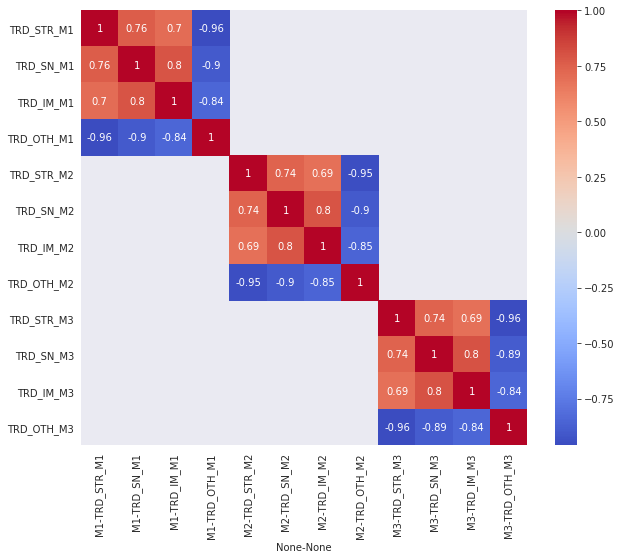

In [71]:
by_month_traffic_data_corr = df_traffic_data_corr.groupby(by=get_month, axis=1).corr()
# by_month_traffic_data_corr
plt.figure(figsize=(10, 8))
sns.heatmap(by_month_traffic_data_corr, annot=True, cmap='coolwarm')

Las variables de consumo de datos agrupadas por mes tienen una correlación bastante alta por lo que se los puede agrupar por mes.

**Número de SMS agrupados por tipo**

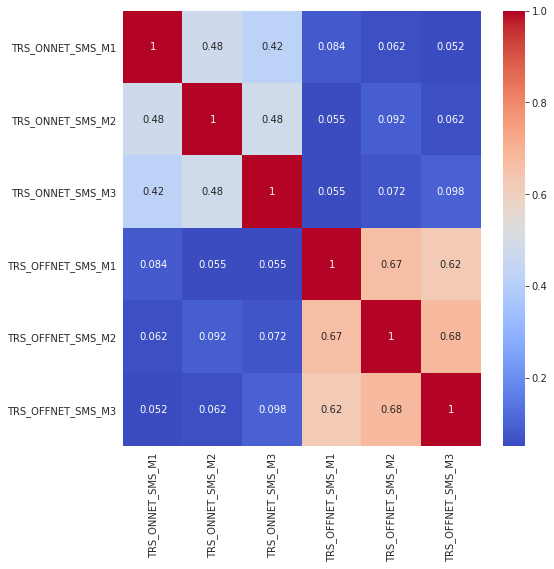

In [72]:
df_n_sms_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRS")]
df_n_sms_corr  = df_traffic[df_n_sms_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(df_n_sms_corr, annot=True, cmap='coolwarm')

### Número de SMS agrupados por mes

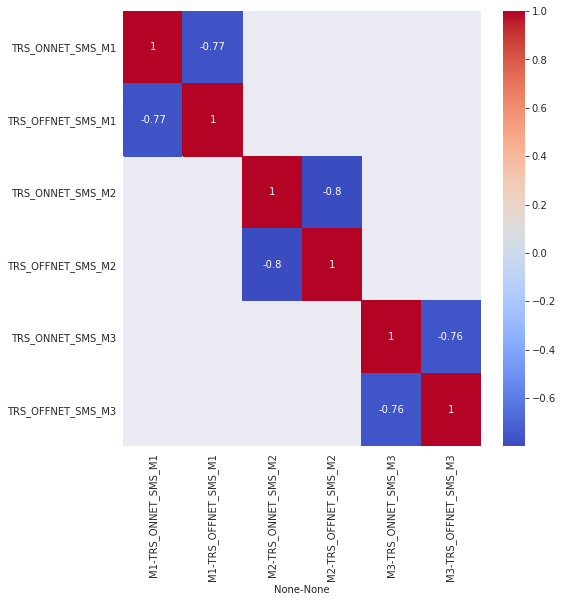

In [73]:
by_month_n_sms_corr = df_n_sms_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(by_month_n_sms_corr, annot=True, cmap='coolwarm')

In [74]:
df_traffic[df_n_sms_columns].describe()

,TRS_ONNET_SMS_M1,TRS_ONNET_SMS_M2,TRS_ONNET_SMS_M3,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,0.173415,0.185037,0.191791,1.216655,1.198780,1.216179
std,0.949936,0.983975,1.002220,2.403954,2.400983,2.459793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.000000,36.000000,36.000000,37.000000,38.000000,30.000000


_Como los datos de SMS están acumulados en torno a cero, se descartarán estas columnas_

**Llamadas por voz agrupadas por tipo**

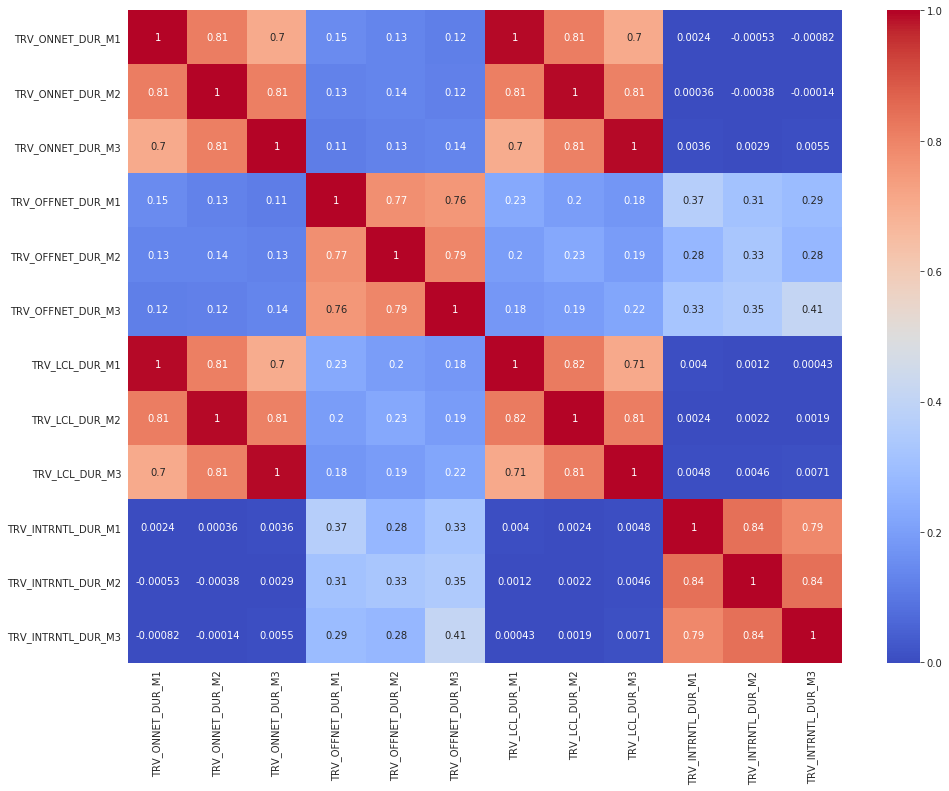

In [75]:
df_voice_minutes_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRV")]
df_voice_minutes_corr = df_traffic[df_voice_minutes_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(df_voice_minutes_corr, annot=True, cmap='coolwarm')

**Llamadas por voz agrupadas por mes**

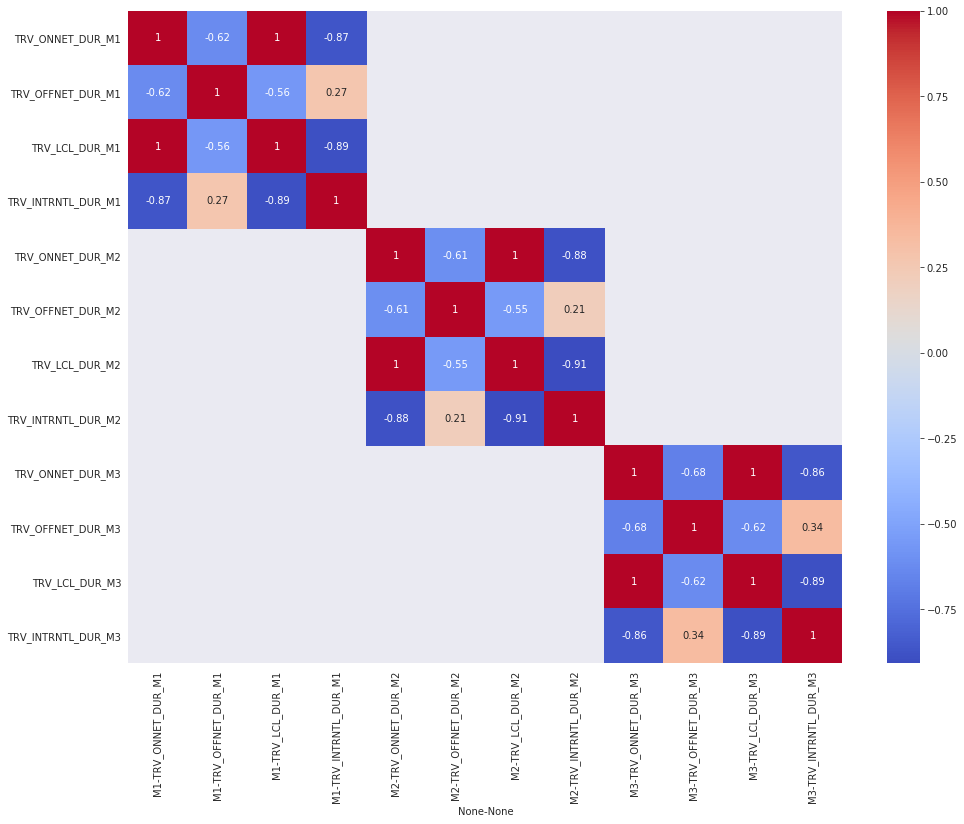

In [76]:
by_month_voice_minutes_corr = df_voice_minutes_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(by_month_voice_minutes_corr, annot=True, cmap='coolwarm')

### Las llamamdas tienen también una alta correlación entre sí por mes, por lo que se podrían agrupar por columnas por mes

--------------------------

# Outliers

## Tráfico de datos

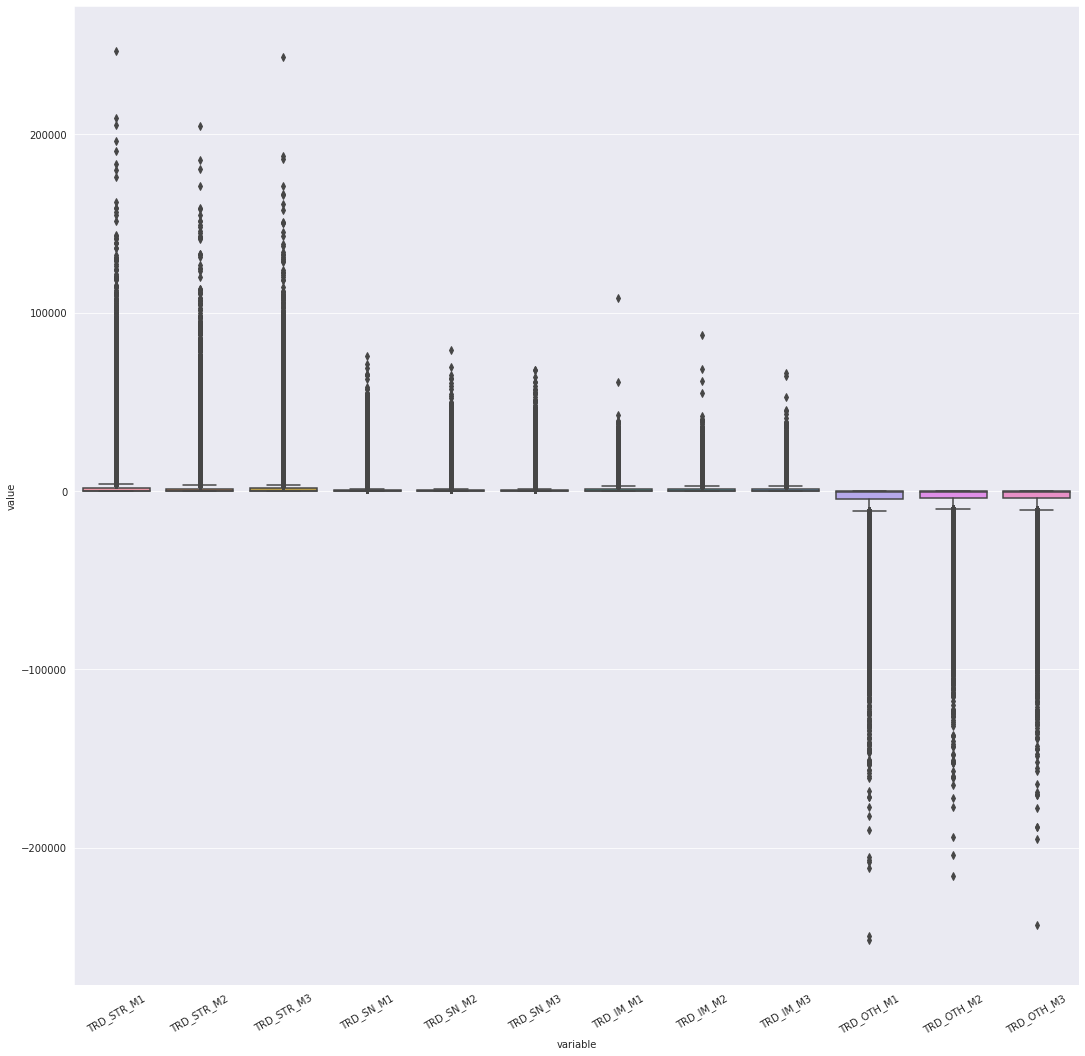

In [77]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_traffic_data_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Llamadas por voz

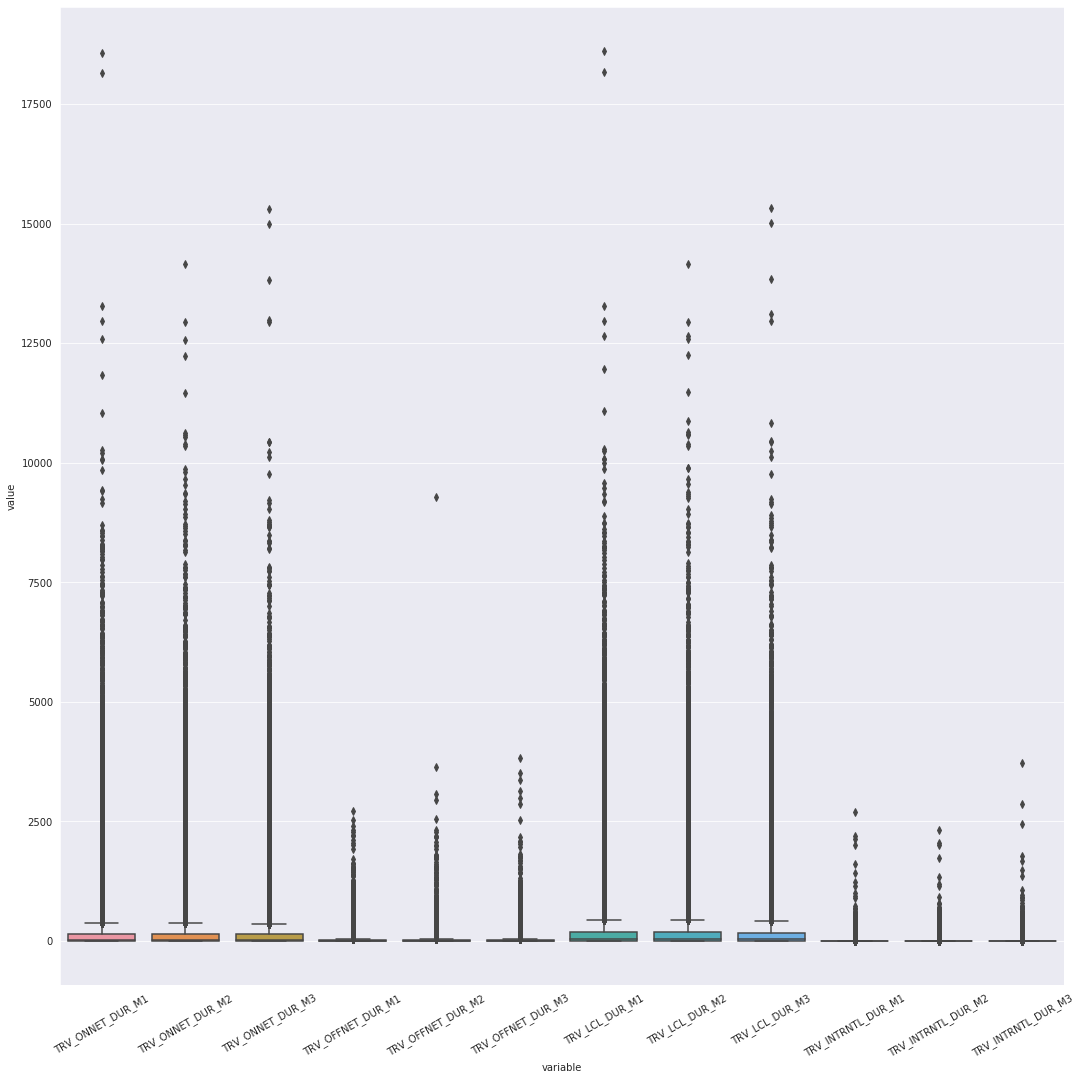

In [78]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_voice_minutes_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Sacando outliers

In [79]:
df_traffic_copy = df_traffic.copy()

In [80]:
df_traffic_data = pd.DataFrame()
for column in df_traffic[df_traffic_data_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_traffic_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


In [ ]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [ ]:
df_voice_data = pd.DataFrame()
for column in df_traffic[df_voice_minutes_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_voice_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


In [ ]:
plt.figure(figsize=(18,16))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_voice_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

**Sacando datos de fulldata**

In [ ]:
fulldata.drop(columns=traffic_columns, inplace=True)

In [ ]:
df_traffic.drop(columns=df_n_sms_columns, inplace=True)

In [ ]:
fulldata.join(other=df_traffic)

---

# Limpieza de datos de recargas

---

In [ ]:
recargas_columns = [recarga_column for recarga_column in fulldata.columns if recarga_column.startswith("PREP")]
Recargas = fulldata[recargas_columns].copy()

In [ ]:
Cant_rec_mes1= Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4'
                        ]].sum(axis=1)
Cant_rec_mes2= Recargas[['PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8'
                        ]].sum(axis=1)
Cant_rec_mes3= Recargas[['PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12'
                        ]].sum(axis=1)

In [ ]:
(Cant_rec_mes1 == Recargas['PREP_RECH_Q_EVT_X1']).value_counts()

In [ ]:
(Cant_rec_mes2 == Recargas['PREP_RECH_Q_EVT_X2']).value_counts()

In [ ]:
(Cant_rec_mes3 == Recargas['PREP_RECH_Q_EVT_X3']).value_counts()

Consideramos que la cantidad de datos que no coinciden es apreciable, entonces decidimos sacar los datos

In [ ]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_X' in x],inplace=True)
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_W' in x],inplace=True)

**Vamos a comparar los montos de recargas acumuladas, con los montos de recargas acumuladas mensuales**

In [ ]:
Mont_rec_mes1= Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4'
                        ]].sum(axis=1)

In [ ]:
Mont_rec_mes2= Recargas[['PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8'
                        ]].sum(axis=1)

In [ ]:
Mont_rec_mes3= Recargas[['PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12'
                        ]].sum(axis=1)

In [ ]:
(Mont_rec_mes1 == Recargas['PREP_RECH_AMT_X1']).value_counts()

In [ ]:
(Mont_rec_mes2 == Recargas['PREP_RECH_AMT_X2']).value_counts()

In [ ]:
(Mont_rec_mes3 == Recargas['PREP_RECH_AMT_X3']).value_counts()

Como los valores difieren en una cantidad indistinguible(menos del 1%) podemos conciderar que presentan la misma información. Por tal motivo se decide sacar las columnas de montos acumulados

In [ ]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_AMT_X' in x],inplace=True)

In [ ]:
fulldata.shape

**Seguimos trabajando con las recargas**

Eliminamos en el dataframe de recargas, las mismas columnas que eliminamos en el fulldata

In [ ]:
def Borrar_columnas(df, grupo_de_columnas):
    df.drop(columns=[x for x in Recargas.columns if grupo_de_columnas in x],inplace=True)

In [ ]:
Borrar_columnas(Recargas,'PREP_RECH_AMT_X')
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_W')
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_X')

In [ ]:
Recargas.shape

### Análisis de correlación

*Correlación entre Cantidad de recargas en x día durante las 12 semanas*

In [ ]:
Cant_rec_en_dias= Recargas[[x for x in Recargas.columns if 'PREP_RECH_Q' in x]]
Cant_rec_en_dias.describe()

In [ ]:
Cant_rec_en_dias.corr()

Vemos que los coeficientes de Pearson entre las variables expresan que no hay correlación entre las variables analizadas

### Correlación entre montos acumulados de recargas por semana

In [ ]:
Mont_Acum_por_sem= Recargas[[x for x in Recargas.columns if 'PREP_RECH_AMT_W' in x]]
Mont_Acum_por_sem.describe()

In [ ]:
Mont_Acum_por_sem.corr()

Los coeficientes de Pearson entre las variables expresan que no hay correlación entre ellas.

### Outliers

**Cantidad de recargas en x dias durante las 12 semanas**

In [ ]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Cant_rec_en_dias))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [ ]:
Cant_rec_en_dias.describe()

Vemos que en todas las columnas el rango intercuartil es 4. Así que vamos a ver cuantas mediciones superan en 1.5 veces el rango (y lo dividimos por el total de filas para obtener una frecuencia relativa). 

In [ ]:
print(((Recargas['PREP_RECH_Q_MON_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_TUE_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_WEN_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_THUR_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_FRI_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SAT_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SUN_12W']>10).value_counts())/ len(Recargas.index)
     )

Además veamos el coeficiente de variación.

In [ ]:
(Recargas['PREP_RECH_Q_MON_12W'].std()/Recargas['PREP_RECH_Q_MON_12W'].mean())*100

**Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes también son superiores al 90%. Por lo tanto, se igualará a todos los valores superiores a dos veces el rango, por el valor de 4+2*R, con el objetivo de influir lo menos posible en la distribución, y que los valores atípicos no influyan de manera apreciable en la media y desvío estándar.**

In [ ]:
fulldata = fulldata[fulldata['PREP_RECH_Q_MON_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_TUE_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_WEN_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_THUR_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_FRI_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_SAT_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_SUN_12W']<=10]

Confirmamos que no hay valores superiores a 10

In [ ]:
((fulldata['PREP_RECH_Q_SAT_12W']>10).value_counts())/ len(fulldata.index)

### Monto acumulado de recargas por semana


In [ ]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Mont_Acum_por_sem))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [ ]:
Mont_Acum_por_sem.describe()

In [ ]:
print(((Recargas['PREP_RECH_AMT_W1']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W2']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W3']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W4']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W5']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W6']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W7']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W8']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W9']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W10']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W11']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W12']>12.5).value_counts())/ len(Recargas.index)
     )

Además veamos el coeficiente de variación.

In [ ]:
(Recargas['PREP_RECH_AMT_W1'].std()/Recargas['PREP_RECH_AMT_W1'].mean())*100

**Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes son muy altos, debido a que el desvío estándar es superior a la media.**

In [ ]:
fulldata = fulldata[fulldata['PREP_RECH_AMT_W1']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W2']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W3']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W4']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W5']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W6']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W7']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W8']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W9']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W10']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W11']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W12']<=12.5]

Confirmamos que no hay valores superiores a 12.5

In [ ]:
((fulldata['PREP_RECH_AMT_W12']>12.5).value_counts())/ len(fulldata.index)

**Días desde la última recarga**

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x=Recargas['PREP_RECH_NDAYS_LASTRECH_12W'])

In [ ]:
Recargas['PREP_RECH_NDAYS_LASTRECH_12W'].describe()

**Se decide no modificar la columna, debido a que el valor máximo que asume la varible es 85, está muy cerca de 3*R+Q3**

---

# Tratamiento de filas según fecha de alta

 ---

Se trabajará la columna de fechas de alta del fulldata

In [ ]:
## Se hará que python interprete a la columna de activación comercial como fecha
fulldata['Date'] = pd.to_datetime(fulldata['COMMERCIAL_ACTIVATION_DATE'], format='%d-%b-%y') 
fulldata['Dayofweek'] = fulldata['Date'].dt.dayofweek 
fulldata['Month'] = fulldata['Date'].dt.month 
fulldata['Year'] = fulldata['Date'].dt.year 
fulldata['Period'] = fulldata['Date'].dt.to_period('M') 
fulldata.sort_values('Date', inplace=True) 

In [ ]:
fulldata[['COMMERCIAL_ACTIVATION_DATE', 'Date', 'Dayofweek', 'Month', 'Year', 'Period']]

Ahora usaremos una tabla pivot para calcular la cantidad de activaciones que por mes en cada año

In [ ]:
pd.pivot_table(data=fulldata, index=['Year'], columns=['Month'], aggfunc=['size'])

**Sacaremos todas las filas de los periodos anteriores al periodo en el cual se dan de alta líneas de manera consecutiva**

In [ ]:
period = pd.to_datetime('2015-05').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]

In [ ]:
pivot_table = pd.pivot_table(data=fulldata, index=['Year'], columns=['Month'], aggfunc=['size'], fill_value=0)
pivot_table

In [ ]:
total_rows = fulldata.shape[0]
total_rows

Ahora veamos que pasa en términos de frecuencias relativas en la tabla pivot

In [ ]:
pivot_table.divide(total_rows) * 100

Vemos que la mayoría de las frecuencias relativas son menores que 4,2 y tenemos valores en junio y julio del 2015 muy superiores al 4,2. Por lo tanto, se decide sacar todo el periodo menor a agosto de 2015, por considerarlos datos erroneos que podrían ensuciar el modelo

In [ ]:
period = pd.to_datetime('2015-08').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]
print(fulldata.shape[0])

---

## Encoding variables categóricas

---

In [ ]:
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(fulldata.columns) - set(num_cols))

In [ ]:
fulldata[cat_columns].nunique()

**Después de inspeccionar estas variables, con imágenes de value counts, nos detenemos en el caso de DEVICE_VENDOR_NAME**

In [ ]:
fulldata.DEVICE_VENDOR_NAME.value_counts(normalize=True)[0:10]

**Vemos que la mayoria se concentra en 6 marcas, remplazaremos con 'Other' para poder aplicar hot encoding**

In [ ]:
n = 6
most_frequent_vendors = fulldata['DEVICE_VENDOR_NAME'].value_counts()[:n].index.tolist()
fulldata.loc[~fulldata["DEVICE_VENDOR_NAME"].isin(most_frequent_vendors), "DEVICE_VENDOR_NAME"] = "Other"

In [ ]:
fulldata.DEVICE_VENDOR_NAME.value_counts(normalize=1)

**Aplicaremos one hot encode a las columnas SEGMENTATION, VALUE_SEGMENT, NETWORK_TECH, DEVICE_VENDOR_NAME**

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [ ]:
fulldata.shape

In [ ]:
columns_to_encode = ['SEGMENTATION', 'VALUE_SEGMENT', 'NETWORK_TECH', 'DEVICE_VENDOR_NAME']
for column in columns_to_encode: 
    fulldata = encode_and_bind(fulldata, column)
fulldata.shape

---

# Correlación variables con target

---

In [ ]:
feature_target_correlation = fulldata[fulldata.columns[1:]].corr()['Target'].dropna()
feature_target_correlation.abs().sort_values(ascending=False)[0:15]

**Consultar**

---

# Entrenamos el modelo

---

In [ ]:
y=fulldata.Target

In [ ]:
columns = [col for col in fulldata.columns if col not in ['SUSCRIBER_KEY','Target']]

In [ ]:
X = fulldata[columns]

In [ ]:
X= X.select_dtypes(include=['int64','float64'])

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape

**Carga del modelo**

In [ ]:
xgb_model = xgb.XGBClassifier()

**Entrenamiento del modelo**

In [ ]:
xgb_model.fit(X_train, y_train)

**Predicción del modelo**

In [ ]:
XGB_preds = xgb_model.predict(X_test)

In [ ]:
XGB_preds

Visualizacion de resultados

In [ ]:
print(classification_report(y_test, XGB_preds))

Analizamos la matriz de confusion

In [ ]:
print(confusion_matrix(y_test, XGB_preds))